# Exploratory data analysis for skeleton joint forecasting

## Let's bring up how many files do we have

In [1]:
import os
from skelcast.data.prepare_data import get_missing_files, get_skeleton_files, filter_missing, should_blacklist

DATA_DIR = os.environ['NTU_RGBD_DATA_DIR']
MISSING_FILES_DIR = '../data/missing'

if not DATA_DIR:
    raise ValueError("NTU_RGBD_DATA_DIR environment variable is not set or empty.")

missing_skel_files = get_missing_files(MISSING_FILES_DIR)
print(f'Missing skeleton files: {len(missing_skel_files)}')
skeleton_files = get_skeleton_files(DATA_DIR)

print(f"Found {len(skeleton_files)} .skeleton files.")

skeleton_files_filtered = filter_missing(skeleton_files=skeleton_files,
                                         missing_skeleton_names=missing_skel_files)

skeleton_files_clean = []
for fname in skeleton_files_filtered:
    if should_blacklist(fname):
        continue
    else:
        skeleton_files_clean.append(fname)

print(f'Skeleton Files size after removing blacklisted files: {len(skeleton_files_clean)}')

nturgb_d.txt
nturgb_d_120.txt
Missing skeleton files: 837
Found 114480 .skeleton files.
Skeleton files after filtering: 114478 files left.
Skeleton Files size after removing blacklisted files: 114122


In [2]:
from skelcast.data.dataset import read_skeleton_file

durations = []
nbodies = []
for fname in skeleton_files_clean:
    mat = read_skeleton_file(fname, save_rgbxy=False, save_depthxy=False, save_skelxyz=True)
    # print(len(mat['nbodys']))
    # print(mat['skel_body0'].shape)
    nbodies.append(mat['nbodys'])
    durations.append(len(mat['nbodys']))

## Let's see what's happening

We first calculate some initial statistics about a small sample of our dataset. We calculate the min, max durations of our activities, and then compute the average and median duration of them.

Then, we move on in padding the entire list, so that all activities have the "same" duration, by adding `-1` values, indicating that there's no person involved in the activity, since the activity finished. We take a small sample from the padded array and plot the number of people involved in an activity w.r.t time. We can see that in some cases, there's a lot happening go on in and out of the scene (see between 483 and 504 in the y-axis of the plot).

Maximum duration of an activity: 300
Minimum duration of an activity: 1
Mean duration of activities: 71.41054310299504
Median of durations of activities: 66.0


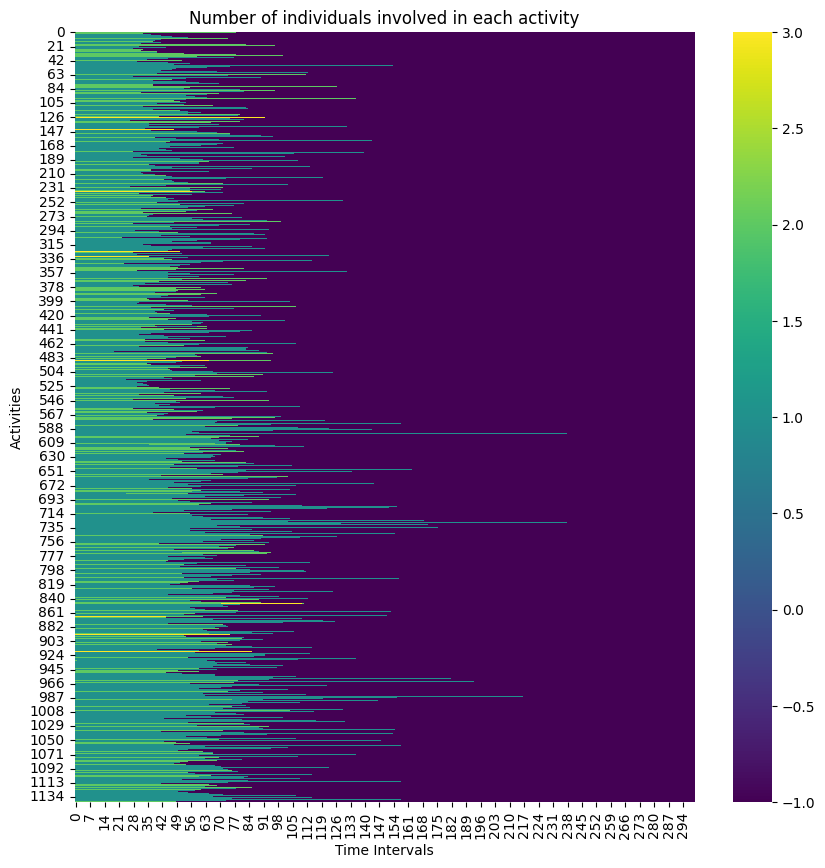

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Maximum duration of an activity: {max(durations)}')
print(f'Minimum duration of an activity: {min(durations)}')
print(f'Mean duration of activities: {np.mean(durations)}')
print(f'Median of durations of activities: {np.median(durations)}')

homogeneous_list = []
for nbody in nbodies:
    diff = max(durations) - len(nbody)
    homogeneous_list.append(nbody + [-1] * diff)

array_of_durations = np.array(homogeneous_list)
# Let's assume 'data' is your numpy array
# You might want to sample or aggregate your data before plotting
# For instance, this is how you could take one out of every 100 activities:
reduced_data = array_of_durations[::100]

# Now, plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(reduced_data, cmap='viridis')
plt.title('Number of individuals involved in each activity')
plt.xlabel('Time Intervals')
plt.ylabel('Activities')
plt.show()

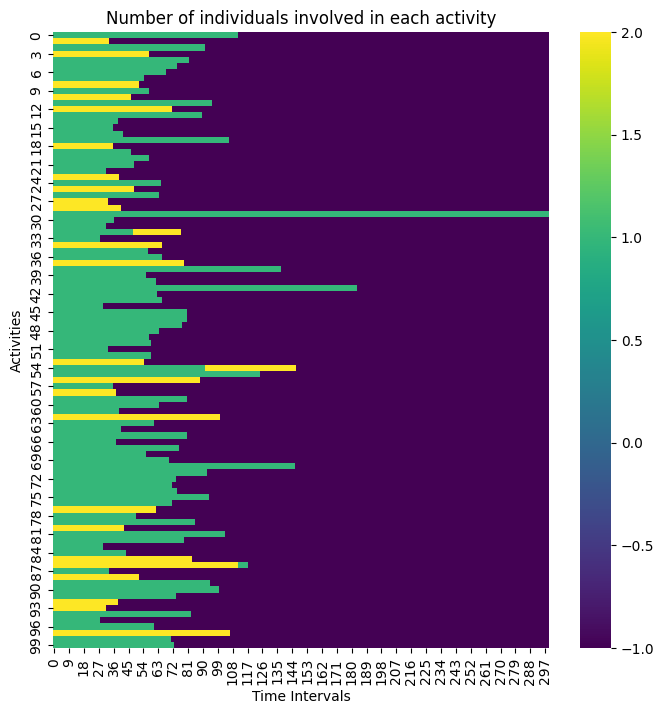

In [48]:
random_indices = np.random.randint(0, array_of_durations.shape[0], 100)

# Now, plotting the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(array_of_durations[random_indices, :], cmap='viridis')
plt.title('Number of individuals involved in each activity')
plt.xlabel('Time Intervals')
plt.ylabel('Activities')
plt.show()

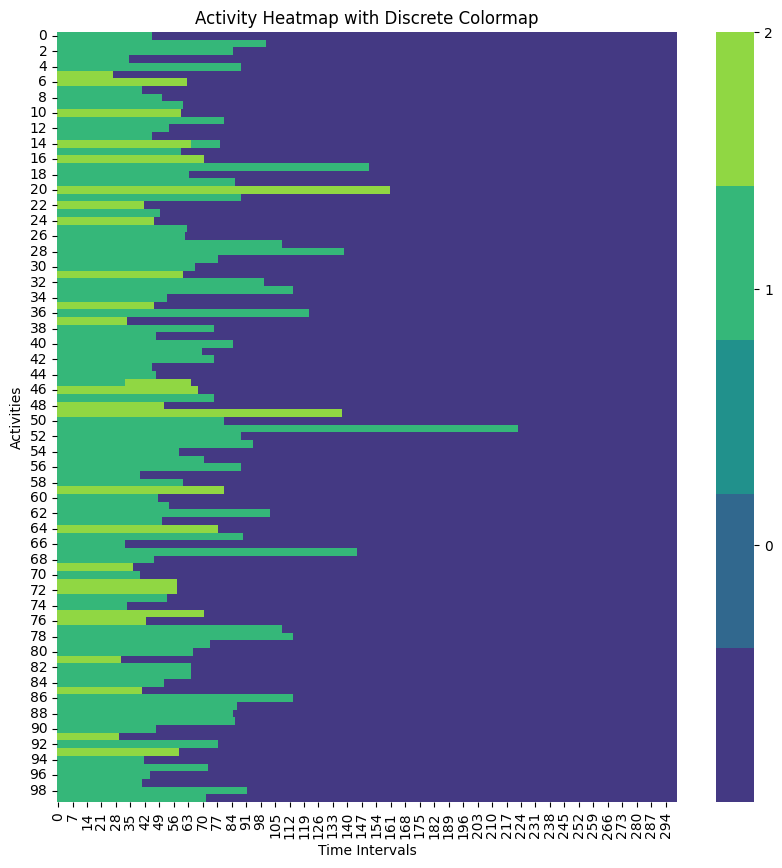

In [57]:
from matplotlib.colors import ListedColormap

random_indices = np.random.randint(0, array_of_durations.shape[0], 100)
# Assuming 'data' is your numpy array and is already loaded
# Optionally reduce the dataset size if necessary
reduced_data = array_of_durations[random_indices, :]

# Define the maximum number of people to set the bins for the colormap
max_people = int(np.max(array_of_durations))
color_bins = max_people + 1  # plus two to include zero

# Create a discrete colormap
cmap = sns.color_palette("viridis", color_bins)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(reduced_data, cmap=ListedColormap(cmap), cbar_kws={'ticks': range(color_bins)})
plt.title('Activity Heatmap with Discrete Colormap')
plt.xlabel('Time Intervals')
plt.ylabel('Activities')
plt.show()

We create a histogram to inspect the distribution of people involved in each activity. As we see, all activities are mostly conducted by 1 person. This clearly indicates that we have to deal with this class imbalance.

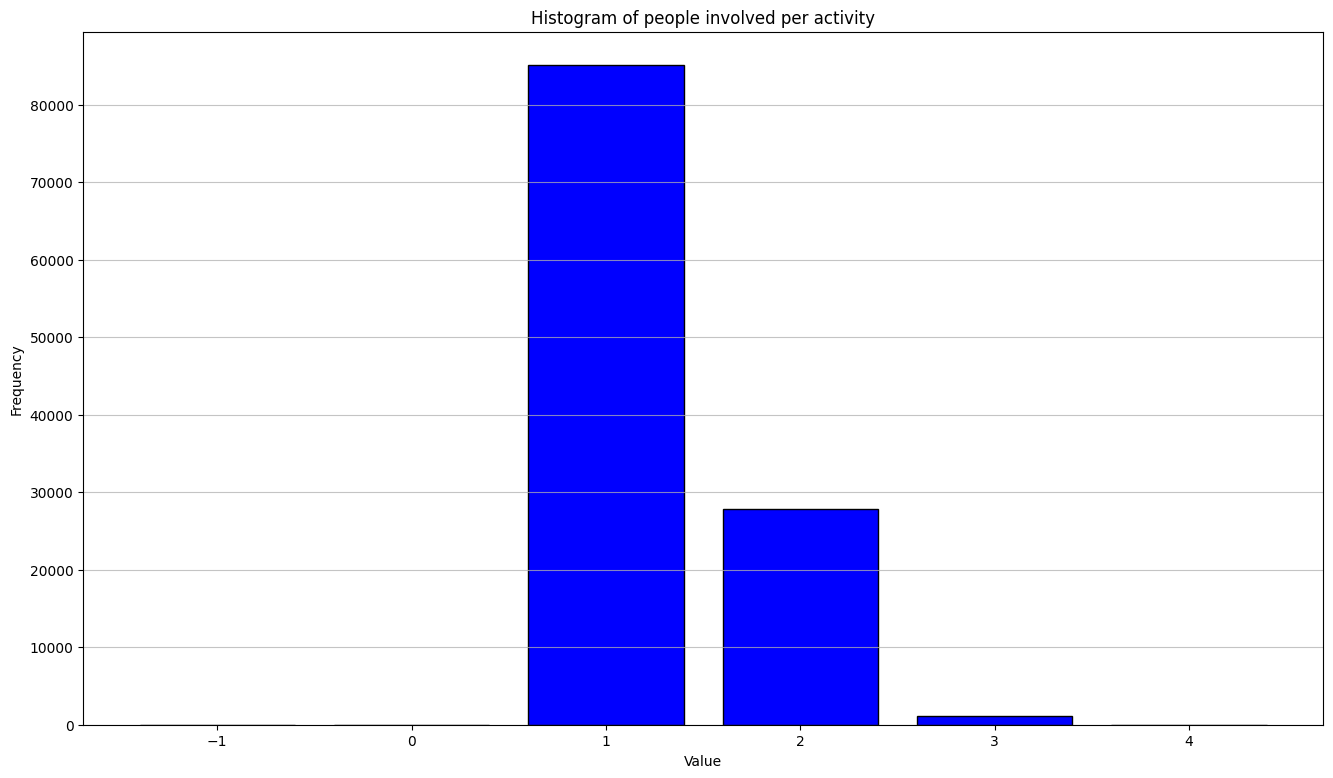

In [77]:
array_max_people = np.max(array_of_durations, axis=1)
bins = np.arange(array_of_durations.min(), array_of_durations.max() + 2) - 0.5
plt.figure(figsize=(16, 9))
counts, edges, patches = plt.hist(array_max_people, bins=bins, rwidth=0.8, color='blue', edgecolor='black')
plt.title('Histogram of people involved per activity')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

We plot the histogram that indicates the distribution of duration per activity. We see that it is positively skewed.

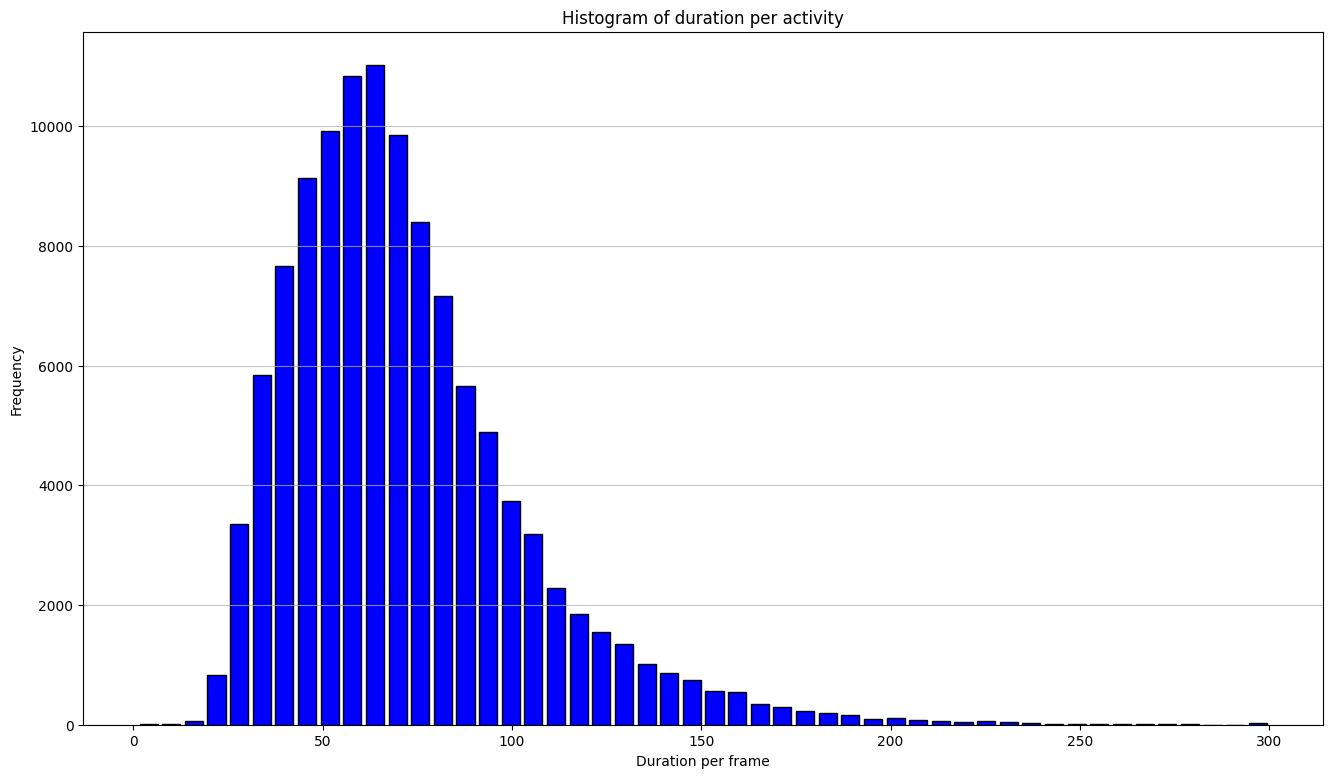

In [81]:
bins = np.arange(min(durations), max(durations) + 2) - 0.5
plt.figure(figsize=(16, 9))
counts, edges, patches = plt.hist(durations, bins=50, rwidth=0.8, color='blue', edgecolor='black')
plt.title('Histogram of duration per activity')
plt.xlabel('Duration per frame')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [1]:
import os
DATA_DIR = os.environ['NTU_RGBD_DATA_DIR']
MISSING_FILES_DIR = '../data/missing'

from skelcast.data.dataset import NTURGBDDataset
import numpy as np

dataset = NTURGBDDataset(data_directory=DATA_DIR, missing_files_dir=MISSING_FILES_DIR)

nturgb_d.txt
nturgb_d_120.txt
Skeleton files after filtering: 114478 files left.


/home/kaseris/Documents/data_ntu_rbgd/nturgbd_skeletons_s001_to_s017/nturgb+d_skeletons/S008C003P035R001A008.skeleton
A008
sitting down.


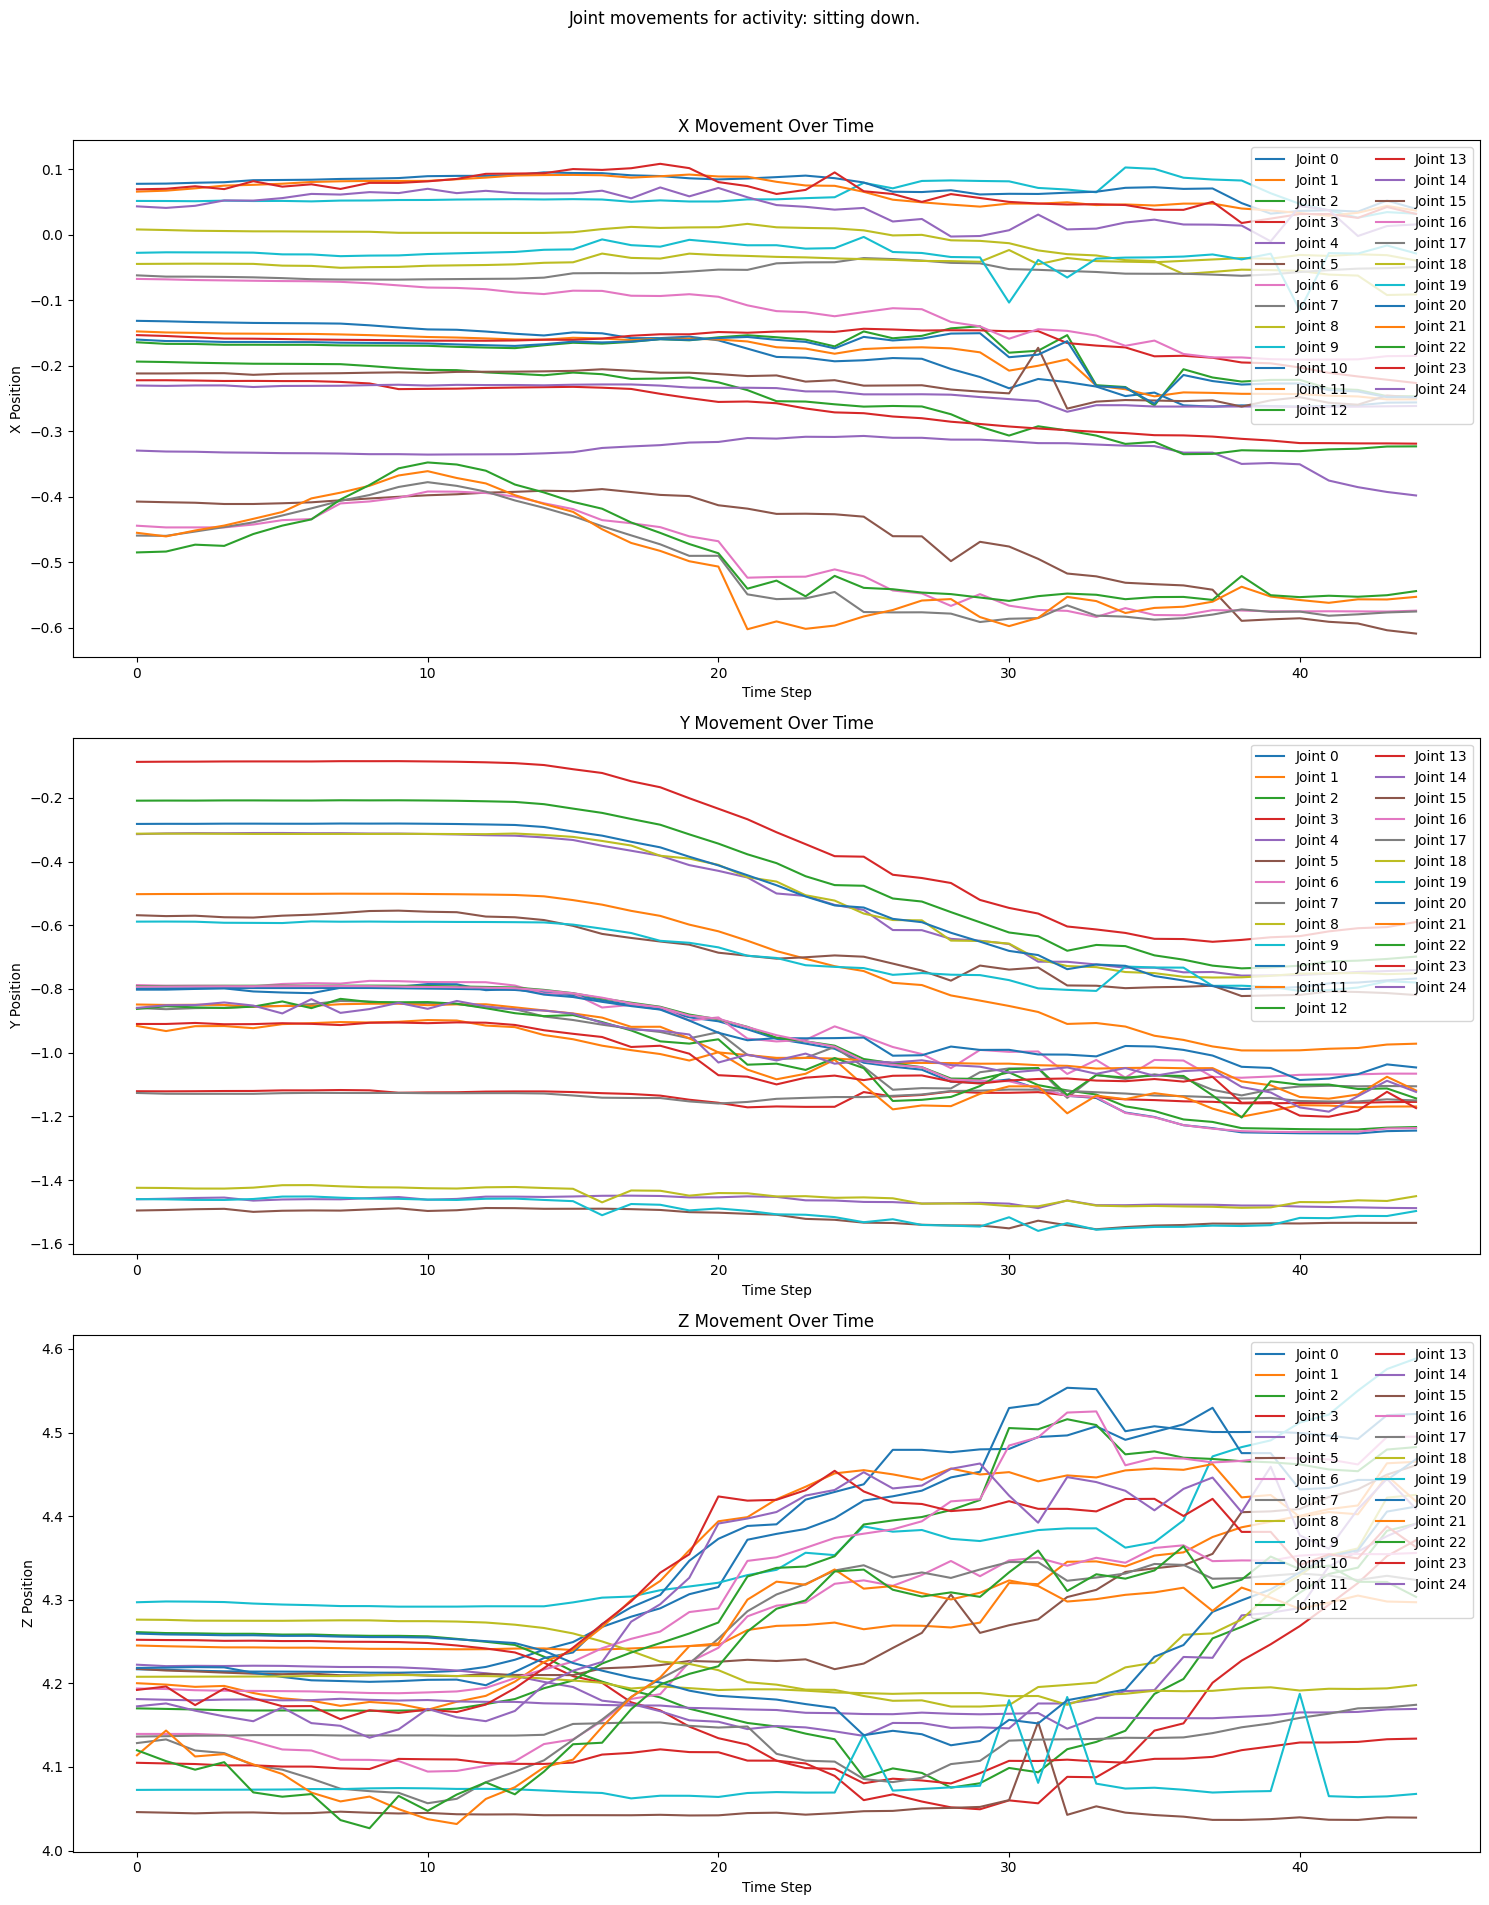

In [24]:
# joint1_over_time = joint1_over_time.numpy()

import matplotlib.pyplot as plt

DURATION = 45

skeletons, label = dataset[68734]
print(label[1])
joints_over_time = skeletons[:DURATION, 0, :, :]
# Assuming your array is named 'movements' and has the shape (300, 3)
# where movements[:, 0] is X, movements[:, 1] is Y, and movements[:, 2] is Z
movements = joints_over_time.numpy() # your 300x25x3 array here
time_steps = range(DURATION)  # Time steps from 0 to 299

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle(f'Joint movements for activity: {label[1]}')
# Plot for each joint
for joint_index in range(25):  # Assuming 25 joints
    axs[0].plot(time_steps, movements[:, joint_index, 0], label=f'Joint {joint_index}')
    axs[1].plot(time_steps, movements[:, joint_index, 1], label=f'Joint {joint_index}')
    axs[2].plot(time_steps, movements[:, joint_index, 2], label=f'Joint {joint_index}')

# X Movement Plot
axs[0].set_title('X Movement Over Time')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('X Position')
axs[0].legend(loc='upper right', ncol=2)

# Y Movement Plot
axs[1].set_title('Y Movement Over Time')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Y Position')
axs[1].legend(loc='upper right', ncol=2)

# Z Movement Plot
axs[2].set_title('Z Movement Over Time')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Z Position')
axs[2].legend(loc='upper right', ncol=2)

# Adjust layout to prevent overlapping

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [11]:
fname = '/home/kaseris/Documents/data_ntu_rbgd/nturgbd_skeletons_s018_to_s032/S029C002P051R001A115.skeleton'
activity_code_with_zeros = os.path.basename(fname)
activity_code_with_zeros.split('.')[0][-4:]

'A115'